<a href="https://colab.research.google.com/github/asheta66/Generative-AI-2/blob/main/B_Class_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [ ]:
# # Install latex
# !sudo apt-get update -y
# !sudo apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
# !pip uninstall -y pandas tensorflow
# !pip install pandas tensorflow
# !pip install seaborn

In [1]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Set the directory for the data stored on Google Drive
data_dir = '/content/drive/My Drive/BrainTumor/256x256'

# Define image size and batch size for data generators
img_size = (256, 256)  # Adjust according to your data
batch_size = 32

# Set up data generators for training and validation with 20% validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='input', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='input', subset='validation')

# Determine the number of classes from the data generator
num_classes = len(train_generator.class_indices)

print("")
# Display the names of the classes and the number of images in each class
print("Class Names and Number of Images:")
for class_name, index in train_generator.class_indices.items():
    num_images = len(os.listdir(os.path.join(data_dir, class_name)))
    print(f"{class_name}: {num_images} images")
print("")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.

Class Names and Number of Images:
glioma: 1426 images
meningioma: 708 images
pituitary tumor: 930 images



**Define the Autoencoder model structure**

In [4]:
# Define the Autoencoder model structure
input_img = Input(shape=(img_size[0], img_size[1], 3))

# Encoder part
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(x)

# Decoder part
x = Dense(128, activation='relu')(encoded)
x = Dense(256, activation='relu')(x)
x = Dense(img_size[0] * img_size[1] * 3, activation='sigmoid')(x)
decoded = Reshape((img_size[0], img_size[1], 3))(x)

# Compile the Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder model
history = autoencoder.fit(train_generator, epochs=10, validation_data=val_generator)

# Extract the encoder part of the Autoencoder for feature extraction
encoder = Model(inputs=input_img, outputs=encoded)

# Define the classification model using the encoded features
encoded_input = Input(shape=(64,))
x = Dense(64, activation='relu')(encoded_input)
x = Dense(num_classes, activation='softmax')(x)
classifier = Model(inputs=encoded_input, outputs=x)

# Compile the classifier model with categorical crossentropy loss
classifier.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

# Generate encoded features for training and validation data
train_features = encoder.predict(train_generator)
val_features = encoder.predict(val_generator)

# Get the corresponding labels and convert them to one-hot encoding
train_labels = train_generator.classes
val_labels = val_generator.classes

train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)

# Train the classifier model using the encoded features
history_classifier = classifier.fit(train_features, train_labels, epochs=50, validation_data=(val_features, val_labels))

# Evaluate the classifier using the training data
train_predictions = np.argmax(classifier.predict(train_features), axis=1)
train_labels_original = np.argmax(train_labels, axis=1)

# Evaluate the classifier using the validation data
val_predictions = np.argmax(classifier.predict(val_features), axis=1)
val_labels_original = np.argmax(val_labels, axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.
Class Names and Number of Images:
glioma: 1426 images
meningioma: 708 images
pituitary tumor: 930 images
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.0217 - val_loss: 0.0067
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 646ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 53s 666ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 662ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 55s 689ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 55s 681ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 667ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 52s 661ms/step - loss: 0.0049 - val_l

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,355 (17.01 KB)

 Trainable params: 4,355 (17.01 KB)

 Non-trainable params: 0 (0.00 B)

77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step
Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3563 - loss: 1.7297 - val_accuracy: 0.3513 - val_loss: 1.1485
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4026 - loss: 1.1533 - val_accuracy: 0.4493 - val_loss: 1.1250
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3913 - loss: 1.1420 - val_accuracy: 0.4150 - val_loss: 1.1213
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4334 - loss: 1.0950 - val_accuracy: 0.4216 - val_loss: 1.1486
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4219 - loss: 1.1059 - val_accuracy: 0.3660 - val_loss: 1.1847
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3899 - loss: 1.1292 - val_accuracy: 0.3676 - val_loss: 1.1065
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4307 - loss: 1.1192 - val_accuracy: 0.4542 - val_loss: 1.1403
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━

**Display Results**

KeyboardInterrupt: 

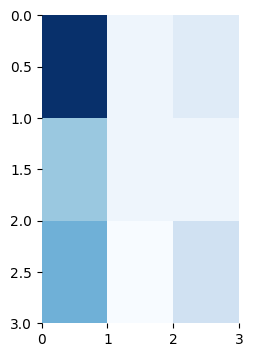

In [23]:
# Display confusion matrices and classification reports
conf_matrix_train = confusion_matrix(train_labels_original, train_predictions)
conf_matrix_val = confusion_matrix(val_labels_original, val_predictions)

plt.figure(figsize=(7, 4))

# Plot training confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys(),
            annot_kws={"size": 10, "weight": "bold"})  # Annotation properties
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=45, ha='right')  # Rotate y-axis labels

# Plot validation confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys(),
            annot_kws={"size": 10, "weight": "bold"})  # Annotation properties
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=45, ha='right')  # Rotate y-axis labels

plt.tight_layout()

# Save the figure to a file
plt.savefig('/content/confusion_matrices.png')

plt.show()

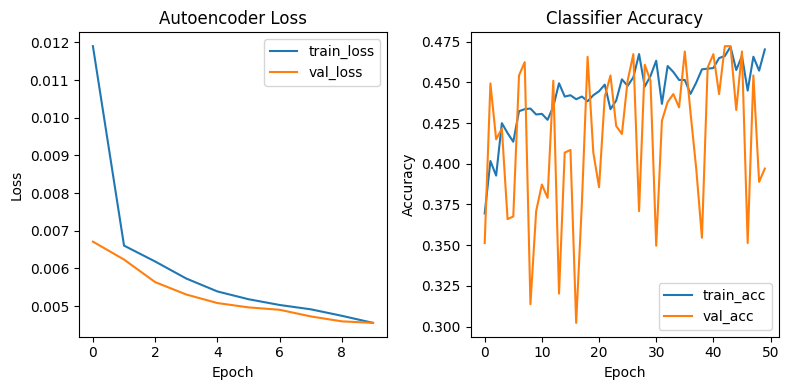

In [15]:
# # Print classification reports
# print("Training Classification Report:")
# print(classification_report(train_labels_original, train_predictions, target_names=train_generator.class_indices.keys()))

# print("Validation Classification Report:")
# print(classification_report(val_labels_original, val_predictions, target_names=val_generator.class_indices.keys()))

# Plot Training and Validation Loss for Autoencoder and Classifier Accuracy
plt.figure(figsize=(8, 4))

# Autoencoder Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.legend()

# Classifier Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='train_acc')
plt.plot(history_classifier.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Found 1141 images belonging to 1 classes.
Found 567 images belonging to 1 classes.
Found 744 images belonging to 1 classes.


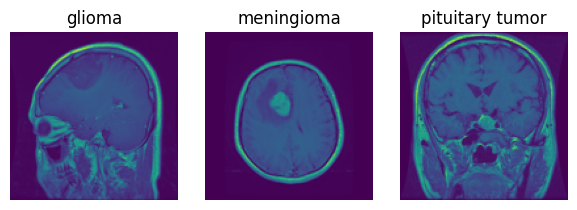

In [20]:
import numpy as np

# Plot 6 random images (1 from each class) in a 2x3 grid
plt.figure(figsize=(6, 4))
class_names = list(train_generator.class_indices.keys())
num_samples_per_class = 1  # Select 1 random image per class

for i, class_name in enumerate(class_names):
    # Fetch a batch of images for the current class
    class_images, _ = next(datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=100,  # Ensure batch size is large enough to include random images
        class_mode='input',
        subset='training',
        shuffle=True,
        classes=[class_name]
    ))

    # Select a random image from the batch
    random_index = np.random.randint(0, class_images.shape[0])
    image = class_images[random_index]

    # Plot the random image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(class_name)

plt.tight_layout()
plt.show()
